In [962]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import combinations, chain
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [984]:
df = pd.read_csv(r"./data/housing_train.csv")

In [985]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

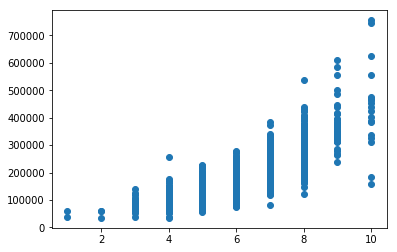

In [986]:
plt.scatter(df['OverallQual'], df['SalePrice'])

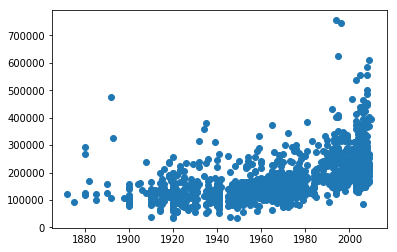

In [987]:
plt.scatter(df['YearBuilt'], df['SalePrice'])

### Generic Transformations:
- Polynomial range: [-2, -1, 1, 2, 3]

1) Linear

2) Polynomial

3) Inverted Polynomial

In [988]:
def powerset(iterable):
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [1331]:
#X = df[['YearBuilt']].copy()
X = df[['YearBuilt', 'OverallQual']].copy()
y = df['SalePrice'].copy()
#X = pd.DataFrame(np.linspace(1, 10))
#y = X[0].copy() ** 2

#print(X)
#print(y)

operations = []
features = pd.DataFrame()
for feat in X.columns:
    min_err = 10e6
    X_trial = pd.DataFrame()
    X_trial[1] = X[feat]
    for deg in range(2, 5):
        X_trial[deg] = X_trial[1] ** deg
    for inv_state, target in enumerate([y, 1/y]):

        for i, combo in enumerate(powerset(X_trial.columns), 1):

            combo = list(combo)
            
            if len(combo) == 1:
                model = LinearRegression
            else:
                model = Lasso
            
            kf = KFold(n_splits=5, shuffle=True)
            err = []
            for train_index, test_index in kf.split(X_trial):
                X_train, X_test = X_trial.loc[train_index, combo], X_trial.loc[test_index, combo]
                y_train, y_test = target[train_index], target[test_index]
                md = model().fit(X_train, y_train)
                y_pred = md.predict(X_test)
                err.append(mean_squared_error(y_test, y_pred))

            avg_err = sum(err)/len(err)
            if avg_err < min_err:
                best_degrees = list(combo)
                md = model().fit(X_trial[combo], target)
                best_intercept = md.intercept_
                best_coefs = list(md.coef_)
                best_inv_state = inv_state
                min_err = avg_err
    if best_inv_state:
        
        denom_str = " + ".join(['{} * {}'.format(x[0], x[1]) for x in zip(best_coefs, best_degrees) if x[0] != 0])
        denom_str += " + {}".format(best_intercept)
        denom_str = '1 / ({})'.format(denom_str)
        
        operations.append((denom_str, feat, best_coefs, best_degrees, True))
        features[denom_str] = np.zeros(len(X))
        for coef, state in zip(best_coefs, best_feature_state):
            if coef != 0:
                features[denom_str] += coef * X_trial[state].values
    else:
        for degree in best_degrees:
            operations.append(('{}_deg{}'.format(feat, degree), feat, [1], [degree], False))
            features[state] = X_trial[state]

C:\Users\olive\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [1332]:
operations

[('1 / (1.779393241057719e-15 * 3 + -2.3801912619123284e-18 * 4 + 2.884549066195303e-05)',
  'YearBuilt',
  [0.0, 1.779393241057719e-15, -2.3801912619123284e-18],
  [1, 3, 4],
  True),
 ('1 / (-1.4765340111848558e-06 * 1 + 1.5499680076099865e-05)',
  'OverallQual',
  [-1.4765340111848558e-06],
  [1],
  True)]

In [1333]:
features.head()

,1 / (1.779393241057719e-15 * 3 + -2.3801912619123284e-18 * 4 + 2.884549066195303e-05),1 / (-1.4765340111848558e-06 * 1 + 1.5499680076099865e-05)
0,0.0,-0.000010
1,0.0,-0.000009
2,0.0,-0.000010
3,0.0,-0.000010
4,0.0,-0.000012


In [1313]:
features.head()

,1 / (1.779393241057719e-15 * YearBuilt_deg3 + -2.3801912619123284e-18 * YearBuilt_deg4 + 2.884549066195303e-05),1 / (-1.4765340111848558e-06 * OverallQual + 1.5499680076099865e-05)
0,-0.000024,-0.000010
1,-0.000023,-0.000009
2,-0.000024,-0.000010
3,-0.000020,-0.000010
4,-0.000024,-0.000012


In [1213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

mod = LinearRegression()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)

e1 = mean_squared_error(y_test, y_pred)
print(e1)

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33)

mod = LinearRegression()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)

e2 = mean_squared_error(y_test, y_pred)
print(e2)

print(e2 < e1)

2480499464.3140388
2385090918.2905593
True


C:\Users\olive\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


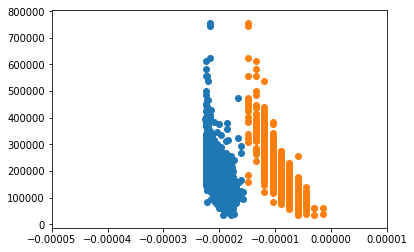

In [1152]:
for feat in features.columns:
    ax = plt.subplot(111)
    plt.scatter(features[feat], y)
    plt.xlim(-0.00005, 0.00001)

C:\Users\olive\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


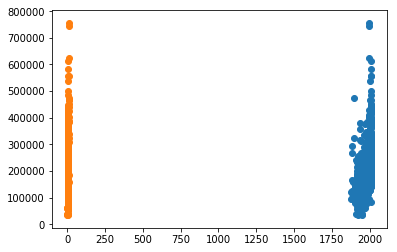

In [1156]:
for feat in X.columns:
    ax = plt.subplot(111)
    plt.scatter(X[feat], y)